# 🇮🇹🇬🇧 Multilingual RAG from a 🎧 podcast


*Notebook by [Stefano Fiorucci](https://github.com/anakin87)*

This notebook shows how to create a multilingual Retrieval Augmented Generation application application, starting from a podcast.

🧰 **Stack**:
- Haystack LLM framework
- OpenAI Whisper model for audio transcription
- Qdrant vector database
- multilingual embedding model: multilingual-e5-large
- multilingual LLM: Mixtral-8x7B-Instruct-v0.1

## Installation

In [ ]:
%%capture
! pip install -U haystack-ai qdrant-haystack "openai-whisper>=20231106" pytube "sentence-transformers>=3.0.0" "huggingface_hub>=0.23.0"

## Podcast transcription

- download the audio from Youtube using `pytube`
- transcribe it locally using Haystack's [`LocalWhisperTranscriber`](https://docs.haystack.deepset.ai/docs/localwhispertranscriber) with the `whisper-small` model. We could use bigger models, which take longer to transcribe. We could also call the paid OpenAI API, using [`RemoteWhisperTranscriber`](https://docs.haystack.deepset.ai/docs/remotewhispertranscriber).

Since the transcription takes some time (about 10 minutes), I commented out the following code and will provide the transcription.

In [2]:
# # https://www.tutorialspoint.com/download-video-in-mp3-format-using-pytube

# from pytube import YouTube

# url = "https://www.youtube.com/watch?v=vrf4_XMSlE0"


# video = YouTube(url)
# stream = video.streams.filter(only_audio=True).first()
# stream.download(filename=f"podcast.mp3")

In [3]:
# from haystack.components.audio import LocalWhisperTranscriber
# from haystack.utils import ComponentDevice

# whisper = LocalWhisperTranscriber(model="small", device=ComponentDevice.from_str("cuda:0"),)
# whisper.warm_up()
# transcription = whisper.run(sources=["podcast.mp3"])

# with open('podcast_transcript_whisper_small.txt.txt', 'w') as fo:
#   fo.write(transcription["documents"][0].content)

## Indexing pipeline

Create an Indexing pipeline that stores chunks of the transcript in the [Qdrant vector database](https://haystack.deepset.ai/integrations/qdrant-document-store).

- [`TextFileToDocument`](https://docs.haystack.deepset.ai/docs/textfiletodocument) converts the transcript into a [Haystack Document](https://docs.haystack.deepset.ai/docs/data-classes#document).
- [`DocumentSplitter`](https://docs.haystack.deepset.ai/docs/documentsplitter) divides the original Document into smaller chunks.
- [`SentenceTransformersDocumentEmbedder`](https://docs.haystack.deepset.ai/docs/sentencetransformersdocumentembedder) computes embeddings(=vector representations) of Documents using a multilingual model, to allow semantic retrieval
- [`DocumentWriter`](https://docs.haystack.deepset.ai/docs/documentwriter) stores the Documents in Qdrant

In [4]:
# download the podcast transcript
# to create the transcript, you can uncomment and run the previous section
!wget "https://raw.githubusercontent.com/deepset-ai/haystack-cookbook/main/data/multilingual_rag_podcast/podcast_transcript_whisper_small.txt"

# let's take a look at the begininning of our 🇮🇹 transcript
!head --bytes 300 podcast_transcript_whisper_small.txt

--2023-12-31 14:25:00--  https://raw.githubusercontent.com/anakin87/mistral-haystack/main/data/podcast_transcript_whisper_small.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61083 (60K) [text/plain]
Saving to: ‘podcast_transcript_whisper_small.txt’

podcast_transcript_ 100%[===================>]  59.65K  --.-KB/s    in 0.01s   

2023-12-31 14:25:00 (5.46 MB/s) - ‘podcast_transcript_whisper_small.txt’ saved [61083/61083]

 Ciao e benvenuti nella puntata 183 del Pointer Podcast, torniamo oggi con degli ospiti, ma prima vi introduto Eugenio, ciao Eugenio. Ciao Luca. Come va? Tutto bene? Tutto bene, tutto bene. Oggi abbiamo due ospiti che arrivano dalla stessa azienda, che è una azienda che produce una libreria che pro

In [5]:
from haystack_integrations.document_stores.qdrant import QdrantDocumentStore
from haystack import Document
from haystack import Pipeline
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder
from haystack.components.converters import TextFileToDocument
from haystack.components.writers import DocumentWriter
from haystack.components.preprocessors import DocumentSplitter
from haystack.utils import ComponentDevice

# initialize the Document store
document_store = QdrantDocumentStore(
    ":memory:",
    embedding_dim=1024,  # the embedding_dim should match that of the embedding model
)

indexing_pipeline = Pipeline()
indexing_pipeline.add_component("text_file_converter", TextFileToDocument())
indexing_pipeline.add_component("splitter", DocumentSplitter(split_by="word", split_length=200))

indexing_pipeline.add_component(
    "embedder",
    SentenceTransformersDocumentEmbedder(
        model="intfloat/multilingual-e5-large",  # good multilingual model: https://huggingface.co/intfloat/multilingual-e5-large
        device=ComponentDevice.from_str("cuda:0"),    # load the model on GPU
        prefix="passage:",  # as explained in the model card (https://huggingface.co/intfloat/multilingual-e5-large#faq), documents should be prefixed with "passage:"
    ))
indexing_pipeline.add_component("writer", DocumentWriter(document_store=document_store))

# connect the components
indexing_pipeline.connect("text_file_converter", "splitter")
indexing_pipeline.connect("splitter", "embedder")
indexing_pipeline.connect("embedder", "writer")

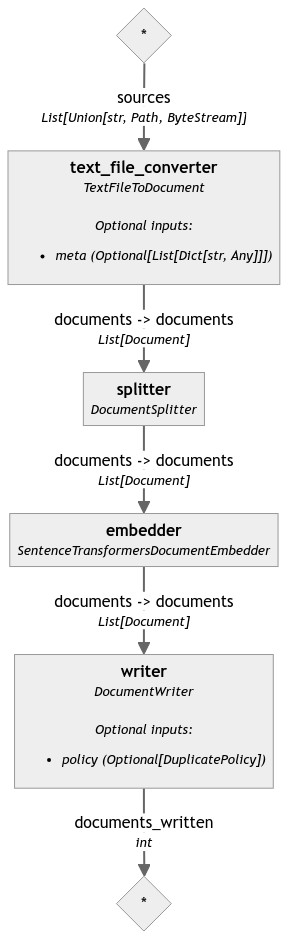

In [6]:
# show the pipeline

from IPython.display import Image

indexing_pipeline.draw('indexing_pipeline.png')
Image('indexing_pipeline.png')

In [7]:
# Run the pipeline! 🚀
res = indexing_pipeline.run({"text_file_converter":{"sources":["podcast_transcript_whisper_small.txt"]}})

.gitattributes:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

onnx/config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/546k [00:00<?, ?B/s]

model.onnx_data:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

onnx/special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

onnx/tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

100it [00:00, 529.46it/s]


In [8]:
document_store.count_documents()

52

## RAG pipeline

Finally our RAG pipeline: from an Italian podcast 🇮🇹🎧 to answering questions in English 🇬🇧

- [`SentenceTransformersTextEmbedder`](https://docs.haystack.deepset.ai/docs/sentencetransformerstextembedder) transforms the query into a vector that captures its semantics, to allow vector retrieval
- `QdrantRetriever` compares the query and Document embeddings and fetches the Documents most relevant to the query.
- [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder) prepares the prompt for the LLM: renders a prompt template and fill in variable values.
- [`HuggingFaceAPIGenerator`](https://docs.haystack.deepset.ai/docs/huggingfaceapigenerator) allows using LLMs via the (free) Hugging Face Serverless Inference API

In [9]:
from haystack.components.generators import HHuggingFaceAPIGenerator
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack_integrations.components.retrievers.qdrant import QdrantEmbeddingRetriever
from pprint import pprint
from getpass import getpass
import os

In [10]:
import os

os.environ["HF_API_TOKEN"] = getpass("Enter your Hugging Face Token: https://huggingface.co/settings/tokens ")

Enter your Hugging Face Token: https://huggingface.co/settings/tokens··········


In [11]:
# load the model (https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1) and try the Generator
# you first need to accept Mistral conditions here: https://huggingface.co/mistralai/Mixtral-8x7B-Instruct-v0.1

generator = HHuggingFaceAPIGenerator(
        api_type="serverless_inference_api",
        api_params={"model": "mistralai/Mistral-7B-Instruct-v0.1"},
        generation_kwargs={"max_new_tokens":500})

generator.run("Please explain in a fun way why vim is the ultimate IDE")

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

{'replies': [".\n\nVim is the ultimate IDE because it's like a ninja warrior of text editors. It's fast, efficient, and deadly accurate. With its powerful modal editing system, you can quickly and easily navigate and manipulate text like a pro. And with its vast array of plugins and customization options, you can tailor it to your specific needs and workflow. Plus, it's available on almost every platform, so you can take it with you wherever you go. Vim is the ultimate IDE for those who want to take their text editing skills to the next level and become true masters of their craft. It's like having a secret weapon in your coding arsenal that gives you an unfair advantage over your competitors. So, if you're ready to join the ranks of the Vim elite, grab your keyboard and get ready to slay some text!"],
 'metadata': [{'model': 'mistralai/Mixtral-8x7B-Instruct-v0.1',
   'index': 0,
   'finish_reason': 'eos_token',
   'usage': {'completion_tokens': 185,
    'prompt_tokens': 14,
    'total

In [12]:
# define a multilingual prompt template

prompt_template = """
Using only the information contained in these documents in Italian, answer the question using English.
If the answer cannot be inferred from the documents, respond \"I don't know\".
Documents:
{% for doc in documents %}
    {{ doc.content }}
{% endfor %}
Question: {{question}}
Answer:
"""

In [13]:
# define the query pipeline
query_pipeline = Pipeline()

query_pipeline.add_component(
    "text_embedder",
    SentenceTransformersTextEmbedder(
        model="intfloat/multilingual-e5-large",  # good multilingual model: https://huggingface.co/intfloat/multilingual-e5-large
        device=ComponentDevice.from_str("cuda:0"),  # load the model on GPU
        prefix="query:",  # as explained in the model card (https://huggingface.co/intfloat/multilingual-e5-large#faq), queries should be prefixed with "query:"
    ))
query_pipeline.add_component("retriever", QdrantEmbeddingRetriever(document_store=document_store))
query_pipeline.add_component("prompt_builder", PromptBuilder(template=prompt_template))
query_pipeline.add_component("generator", generator)

# connect the components
query_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
query_pipeline.connect("retriever.documents", "prompt_builder.documents")
query_pipeline.connect("prompt_builder", "generator")

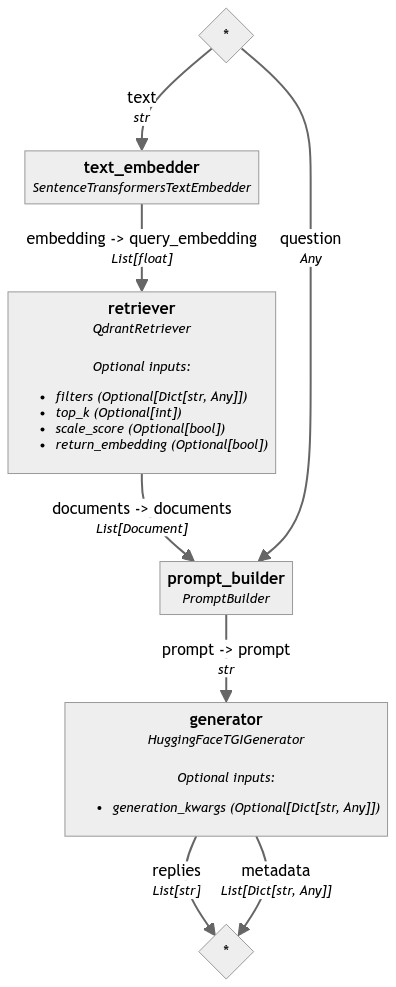

In [14]:
# show the pipeline

from IPython.display import Image

query_pipeline.draw('query_pipeline.png')
Image('query_pipeline.png')

In [15]:
# try the pipeline

question = "What is Pointer Podcast?"
results = query_pipeline.run(
    {   "text_embedder": {"text": question},
        "prompt_builder": {"question": question},
    }
)

for d in results['generator']['replies']:
  pprint(d)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(' The Pointer Podcast is an Italian language podcast available on Apple '
 'Podcast, Google Podcast, and Spotify. It covers various topics, including '
 'NLP (Natural Language Processing) and LLM (Large Language Model). The hosts '
 'interview experts in the field, and listeners can contact the podcast via '
 'email or social media.')


✨ Nice!

In [16]:
# let's create a simple wrapper to call the pipeline and show the answers

def ask_rag(question: str):
  results = query_pipeline.run(
      {
          "text_embedder": {"text": question},
          "prompt_builder": {"question": question},
      }
  )

  for d in results["generator"]["replies"]:
      pprint(d)

## Try our multilingual RAG application!

In [17]:
import random

In [18]:
questions="""What are some interesting directions in Large Language Models?
What is Haystack?
What is Ollama?
How did Stefano end up working at deepset?
Will open source models achieve the quality of closed ones?
What are the main features of Haystack?
Summarize in a bulleted list the main stages of training a Large Language Model
What is Zephyr?
What is it and why is the quantization of Large Language Models interesting?
Could you point out the names of the hosts and guests of the podcast?""".split("\n")

In [19]:
q = random.choice(questions)
print(q)
ask_rag(q)

Will open source models achieve the quality of closed ones?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(' The documents suggest that open source models are reaching the performance '
 'levels of closed models, and there is a paper from Aggin Face that '
 'demonstrates a technique for distilling the characteristics of larger models '
 'into smaller ones using human preference alignment with minimal human '
 'supervision. This allows for the creation of smaller models that replicate '
 'some of the capabilities of larger models, which can be useful for the end '
 'user. The report and recipe for this technique have been released and can be '
 'replicated with a relatively small budget. The documents also indicate that '
 'open source models are having an important impact on the field, not just '
 'from big companies like Open AI and Microsoft, but also from smaller '
 'companies or individuals releasing open source models. However, there is a '
 'tension between open source and proprietary models that is not likely to be '
 'resolved soon. The quality and variety of open source models con